# Adam: Exercise

For this exercise we will be build Adam up from scratch starting with regular gradient descent. We will also be utilizing mini batches to introduce stochasticity to the optimization. 

We will be working with the mnist_784 data set and a simple shallow neural network. 

If you do not have scikit-learn then you can get it here: https://scikit-learn.org/stable/install.html

This code is heavily inspired by Doug’s code from CSCI 447/547 lecture 05_multilayer_perceptron.

First we need to get the data, define the network and define some functions to perform on the data. You don’t need to do anything with this first block of code. 

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# In order to run this in class, we're going to reduce the dataset by a factor of 5
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X[::5]
y = y.astype(int)[::5]
X, X_test, y, y_test = train_test_split(X, y)

# Here we specify the size of our neural network.
# We are mapping from 784 to 10 with 256 hiden layer nodes.

m = len(X)
n_0 = 784
n_1 = 256
N = 10


# Function to convert categorical labels into one-hot matrix.
def convert_to_one_hot(y, n_classes):
    T = np.zeros((y.shape[0], n_classes))
    for t, yy in zip(T, y):
        t[yy] = 1
    return T


# Convert the data to one hot notation
one_hot_y_actual = convert_to_one_hot(y, N)
one_hot_y_test = convert_to_one_hot(y_test, N)


# Sigmoid function (activation)
def sigmoid(a):
    return 1. / (1 + np.exp(-a))


# Softmax function (final layer for classification)
def softmax(A):
    numerator = np.exp(A)
    denominator = numerator.sum(axis=1)
    return numerator / denominator[:, np.newaxis]


# Categorical cross-entropy
def L(T, S, W1, W2, alpha_1=1e-2, alpha_2=1e-5):
    return -1. / len(T) * np.sum(T * np.log(S)) + np.sum(0.5 * alpha_1 * W1 ** 2) + np.sum(0.5 * alpha_2 * W2 ** 2)


# Run the neural network forward, given some weights and biases
def feedforward(X, W1, W2, b1, b2):
    # Feedforward
    A1 = X @ W1 + b1
    Z1 = sigmoid(A1)
    A2 = Z1 @ W2 + b2
    y_pred = softmax(A2)
    return y_pred, Z1


# Compute the neural network gradients using backpropagation
def backpropogate(y_pred, Z1, X, y_obs, alpha_1=1e-2, alpha_2=1e-5):
    # Backpropogate
    delta_2 = (1. / len(y_pred)) * (y_pred - y_obs)
    grad_W2 = Z1.T @ delta_2 + alpha_2 * W2
    grad_b2 = delta_2.sum(axis=0)

    delta_1 = delta_2 @ W2.T * Z1 * (1 - Z1)
    grad_W1 = X.T @ delta_1 + alpha_1 * W1
    grad_b1 = delta_1.sum(axis=0)
    return grad_W1, grad_W2, grad_b1, grad_b2


def mini_batch(x_sample, y_sample, start_batch_size):
    """
    Takes a copy of x_sample and y_sample and returns mini batch matrices of both and number of batches
    """

    # Batches must divide evenly into total number of samples for numpy arrays to be happy.
    # Gets number of bathes by finding next smallest number that evenly divides
    num_batches = start_batch_size
    while len(x_sample) % num_batches != 0:
        num_batches -= 1

    # randomly shuffle indices
    np.random.seed(42)
    random_indices = np.random.choice(range(len(x_sample)), len(x_sample), replace=False)

    # instantiate lists to hold batches
    x_list = [[] for i in range(num_batches)]
    y_list = [[] for i in range(num_batches)]

    # populate batches matrix with random mini batch indices
    for i in range(len(x_sample)):

        x_list[i // 105].append(x_sample[random_indices[i]])
        y_list[i // 105].append(y_sample[random_indices[i]])
    
    # Convert to numpy arrays
    x_batch = np.array(x_list)
    y_batch = np.array(y_list)

    return x_batch, y_batch, num_batches, num_batches


# Vanilla Gradient Descent

For our first exercise we will implement plain old gradient descent. The mathematical formula is:

$$ \theta_t = \theta_{t-1} - \alpha \nabla f(\theta_{t-1}) \tag{1}$$
---

We have already specified initial values for the $\alpha$ and the batch size but feel free to play around with it. The location to insert your gradient descent implementation is outlined with a multi-line comment.  

In [3]:
"""
Vanilla Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
vanilla_loss = []

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)
        
        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        W1 = W1 - eta * grad_W1
        W2 = W2 - eta * grad_W2
        b1 = b1 - eta * grad_b1
        b2 = b2 - eta * grad_b2

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    vanilla_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))



Epoch 0 Loss 2.305860 Accuracy 0.094571
Epoch 10 Loss 2.296862 Accuracy 0.094571
Epoch 20 Loss 2.287282 Accuracy 0.094571
Epoch 30 Loss 2.276646 Accuracy 0.129714
Epoch 40 Loss 2.264672 Accuracy 0.185714
Epoch 50 Loss 2.251203 Accuracy 0.221143
Epoch 60 Loss 2.236175 Accuracy 0.350286
Epoch 70 Loss 2.219607 Accuracy 0.500571
Epoch 80 Loss 2.201607 Accuracy 0.586286
Epoch 90 Loss 2.182327 Accuracy 0.630857
Epoch 100 Loss 2.161933 Accuracy 0.638571
Epoch 110 Loss 2.140595 Accuracy 0.634000
Epoch 120 Loss 2.118477 Accuracy 0.631429
Epoch 130 Loss 2.095723 Accuracy 0.628286
Epoch 140 Loss 2.072461 Accuracy 0.625143
Epoch 150 Loss 2.048814 Accuracy 0.623429
Epoch 160 Loss 2.024907 Accuracy 0.620857
Epoch 170 Loss 2.000852 Accuracy 0.622571
Epoch 180 Loss 1.976730 Accuracy 0.625429
Epoch 190 Loss 1.952612 Accuracy 0.627714
Epoch 200 Loss 1.928559 Accuracy 0.629429
Epoch 210 Loss 1.904622 Accuracy 0.632857
Epoch 220 Loss 1.880846 Accuracy 0.635429
Epoch 230 Loss 1.857267 Accuracy 0.640571
Epo

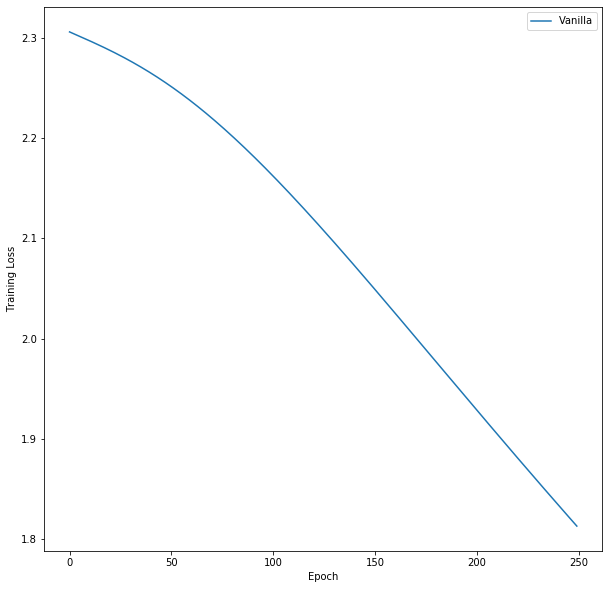

In [5]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# Momentum Gradient Descent

Next we will add momentum. The the new update rule is:

$$m_{t}=\beta_{1} m_{t-1} + (1 - \beta_{1})\nabla f(\theta_{t-1})$$
---

$$ \beta_1 \in [0,1)$$
---

$$\theta_{t}=\theta_{t-1} - \alpha m_{t} \tag{2}$$
---

In [6]:

"""
Momentum Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250

beta_1 = 0.90
"""
You need to add another hyper parameter here. Hint! look at the equation above
"""

# data for analysis
momentum_loss = []

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

"""
You probably need to initialize your momentum here... 
"""

m_W1 = np.zeros((n_0, n_1))
m_W2 = np.zeros((n_1, N))
m_b1 = np.zeros((1, n_1))
m_b2 = np.zeros((1, N))

# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        
        m_W1 = (beta_1 * m_W1) + (1 - beta_1) * grad_W1
        m_W2 = (beta_1 * m_W2) + (1 - beta_1) * grad_W2
        m_b1 = (beta_1 * m_b1) + (1 - beta_1) * grad_b1
        m_b2 = (beta_1 * m_b2) + (1 - beta_1) * grad_b2
        
        W1 = W1 - eta * m_W1
        W2 = W2 - eta * m_W2
        b1 = b1 - eta * m_b1
        b2 = b2 - eta * m_b2
        

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    momentum_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.305940 Accuracy 0.094571
Epoch 10 Loss 2.296949 Accuracy 0.094571
Epoch 20 Loss 2.287392 Accuracy 0.094571
Epoch 30 Loss 2.276786 Accuracy 0.128571
Epoch 40 Loss 2.264848 Accuracy 0.185714
Epoch 50 Loss 2.251418 Accuracy 0.220000
Epoch 60 Loss 2.236431 Accuracy 0.347714
Epoch 70 Loss 2.219904 Accuracy 0.498000
Epoch 80 Loss 2.201943 Accuracy 0.585714
Epoch 90 Loss 2.182699 Accuracy 0.630571
Epoch 100 Loss 2.162336 Accuracy 0.638286
Epoch 110 Loss 2.141027 Accuracy 0.634000
Epoch 120 Loss 2.118934 Accuracy 0.631143
Epoch 130 Loss 2.096200 Accuracy 0.628571
Epoch 140 Loss 2.072957 Accuracy 0.625429
Epoch 150 Loss 2.049325 Accuracy 0.623714
Epoch 160 Loss 2.025429 Accuracy 0.620857
Epoch 170 Loss 2.001382 Accuracy 0.622857
Epoch 180 Loss 1.977266 Accuracy 0.625429
Epoch 190 Loss 1.953152 Accuracy 0.627714
Epoch 200 Loss 1.929101 Accuracy 0.629429
Epoch 210 Loss 1.905165 Accuracy 0.632857
Epoch 220 Loss 1.881388 Accuracy 0.635429
Epoch 230 Loss 1.857806 Accuracy 0.640571
Epo

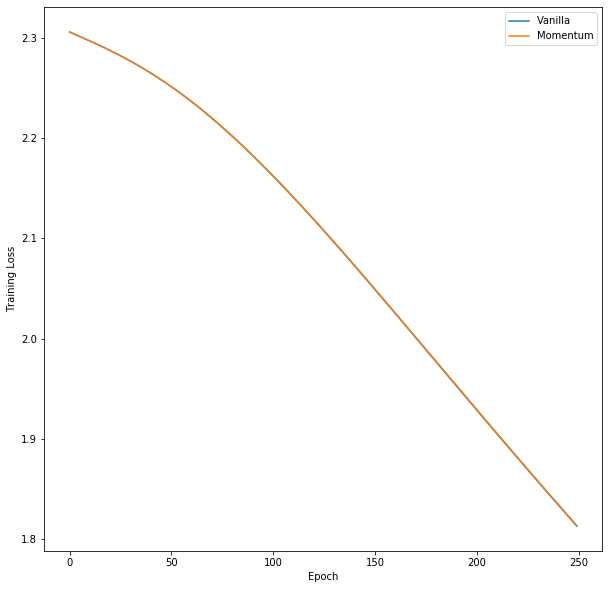

In [7]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# RMSProp Gradient Descent 

Next we will do RMSProp. The update rule is as follows:

$$v_{t} = \beta_{2}v_{t-1} + (1 - \beta_{2})\nabla f(\theta_{t-1})^2$$
---

$$ \beta_2 \in [0,1)$$
---

$$\theta_{t} = \theta_{t-1} - \alpha \frac { \nabla f(\theta_{t-1})}{\sqrt{v_{t} + \epsilon}} \tag{3}$$ 
---


In [8]:
"""
RMSProp Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
"""
You need to add two hyper parameters here. Hint! look at the equation above
"""
beta_2 = 0.99
epsilon = 1e-10

# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
RMS_loss = []

"""
You probably need to initialize your variance here...
"""
v_W1 = np.zeros((n_0, n_1))
v_W2 = np.zeros((n_1, N))
v_b1 = np.zeros((1, n_1))
v_b2 = np.zeros((1, N))


# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        v_W1 = (beta_2 * v_W1) + (1 - beta_2) * np.square(grad_W1)
        v_W2 = (beta_2 * v_W2) + (1 - beta_2) * np.square(grad_W2)
        v_b1 = (beta_2 * v_b1) + (1 - beta_2) * np.square(grad_b1)
        v_b2 = (beta_2 * v_b2) + (1 - beta_2) * np.square(grad_b2)
        
        W1 = W1 - eta * (grad_W1 / np.sqrt(v_W1 + epsilon))
        W2 = W2 - eta * (grad_W2 / np.sqrt(v_W2 + epsilon))
        b1 = b1 - eta * (grad_b1 / np.sqrt(v_b1 + epsilon))
        b2 = b2 - eta * (grad_b2 / np.sqrt(v_b2 + epsilon))
       

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    RMS_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.100486 Accuracy 0.737143
Epoch 10 Loss 1.334452 Accuracy 0.866286
Epoch 20 Loss 0.857974 Accuracy 0.886857
Epoch 30 Loss 0.578477 Accuracy 0.898286
Epoch 40 Loss 0.416932 Accuracy 0.906571
Epoch 50 Loss 0.320234 Accuracy 0.910571
Epoch 60 Loss 0.258396 Accuracy 0.912000
Epoch 70 Loss 0.215885 Accuracy 0.914000
Epoch 80 Loss 0.185095 Accuracy 0.917143
Epoch 90 Loss 0.161913 Accuracy 0.918000
Epoch 100 Loss 0.143594 Accuracy 0.919143
Epoch 110 Loss 0.128513 Accuracy 0.920857
Epoch 120 Loss 0.116047 Accuracy 0.923143
Epoch 130 Loss 0.105644 Accuracy 0.924571
Epoch 140 Loss 0.096656 Accuracy 0.924571
Epoch 150 Loss 0.089076 Accuracy 0.924857
Epoch 160 Loss 0.082397 Accuracy 0.924571
Epoch 170 Loss 0.076492 Accuracy 0.926000
Epoch 180 Loss 0.071233 Accuracy 0.926571
Epoch 190 Loss 0.066736 Accuracy 0.928000
Epoch 200 Loss 0.062569 Accuracy 0.927714
Epoch 210 Loss 0.058766 Accuracy 0.927429
Epoch 220 Loss 0.055293 Accuracy 0.927714
Epoch 230 Loss 0.052118 Accuracy 0.927143
Epo

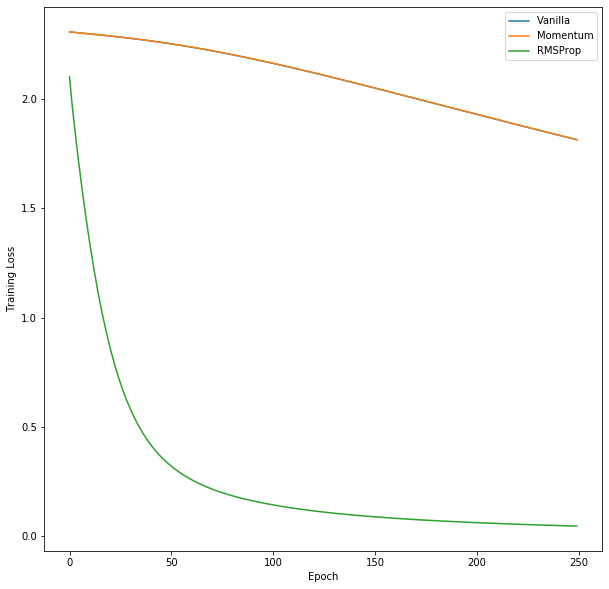

In [9]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

# Adam Gradient Descent 

Now we put them both together and we get Adam!

$$m_{t}=\beta_{1} m_{t-1} + (1 - \beta_{1})\nabla f(\theta_{t-1})$$
---

$$v_{t} = \beta_{2}v_{t-1} + (1 - \beta_{2})\nabla f(\theta_{t-1})^2$$
---

$$\hat m_{t} = \frac {m_{t}}{1 - \beta_1^{t}}$$
---

$$\hat v_t = \frac {v_{t}}{1 - \beta_2^{t}}$$
---

$$\theta_t = \theta_{t-1} - \alpha \frac {\hat m_t}{\sqrt{\hat v_t + \epsilon}} \tag{4}$$
---

Play around with the hyperparameters to see if you can get distinctly different behavior from the optimization.

In [10]:
"""
Adam Gradient Descent
"""

# Hyper Parameters
eta = 1e-5
initial_batch_size = 104
epochs = 250
"""
You need to add 3 hyper parameters here. Hint! look at the equation above
"""
beta_1 = 0.9
beta_2 = 0.99
epsilon = 1e-10


# Initialize random parameter matrices
np.random.seed(42)
W1 = 0.001 * np.random.randn(n_0, n_1)
W2 = 0.001 * np.random.randn(n_1, N)

b1 = 0.1 * np.random.randn(1, n_1)
b2 = 0.1 * np.random.randn(1, N)

# data for analysis
Adam_loss = []

"""
You probably need to initialize your variance and momentum here...
"""
v_W1 = np.zeros((n_0, n_1))
v_W2 = np.zeros((n_1, N))
v_b1 = np.zeros((1, n_1))
v_b2 = np.zeros((1, N))

m_W1 = np.zeros((n_0, n_1))
m_W2 = np.zeros((n_1, N))
m_b1 = np.zeros((1, n_1))
m_b2 = np.zeros((1, N))


# Perform gradient descent
for i in range(epochs):

    # generate mini batches
    x_batches, y_batches, num_batches, actual_batch_size = mini_batch(X, one_hot_y_actual, initial_batch_size)

    # perform gradient descent on mini batches
    for j in range(num_batches):
        y_pred, Z1 = feedforward(x_batches[j], W1, W2, b1, b2)

        """
        These are your gradients with respect to weight matrices W1 and W2 
        as well as your biases b1 and b2
        """
        grad_W1, grad_W2, grad_b1, grad_b2 = backpropogate(y_pred, Z1, x_batches[j], y_batches[j])

        """
        You put your code here. W1 and W2 are your weight matrices.
        b1 and b2 are your bias for each matrix.
        Each are numpy arrays.
        """
        
        m_W1 = (beta_1 * m_W1) + (1 - beta_1) * grad_W1
        m_W2 = (beta_1 * m_W2) + (1 - beta_1) * grad_W2
        m_b1 = (beta_1 * m_b1) + (1 - beta_1) * grad_b1
        m_b2 = (beta_1 * m_b2) + (1 - beta_1) * grad_b2
        
        v_W1 = (beta_2 * v_W1) + (1 - beta_2) * np.square(grad_W1)
        v_W2 = (beta_2 * v_W2) + (1 - beta_2) * np.square(grad_W2)
        v_b1 = (beta_2 * v_b1) + (1 - beta_2) * np.square(grad_b1)
        v_b2 = (beta_2 * v_b2) + (1 - beta_2) * np.square(grad_b2)
        
        m_hat_W1 = m_W1 / (1 - beta_1**(i*j+1))
        m_hat_W2 = m_W2 / (1 - beta_1**(i*j+1))
        m_hat_b1 = m_b1 / (1 - beta_1**(i*j+1))
        m_hat_b2 = m_b2 / (1 - beta_1**(i*j+1))
        
        v_hat_W1 = v_W1 / (1 - beta_2**(i*j+1))
        v_hat_W2 = v_W2 / (1 - beta_2**(i*j+1))
        v_hat_b1 = v_b1 / (1 - beta_2**(i*j+1))
        v_hat_b2 = v_b2 / (1 - beta_2**(i*j+1))
        
        W1 = W1 - eta * (m_hat_W1 / np.sqrt(v_hat_W1 + epsilon))
        W2 = W2 - eta * (m_hat_W2 / np.sqrt(v_hat_W2 + epsilon))
        b1 = b1 - eta * (m_hat_b1 / np.sqrt(v_hat_b1 + epsilon))
        b2 = b2 - eta * (m_hat_b2 / np.sqrt(v_hat_b2 + epsilon))

        

    # calc loss at end of each epoch
    y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
    Adam_loss.append(L(one_hot_y_actual, y_entire_pred, W1, W2))

    # Print some summary statistics every ten iterations
    if i % 10 == 0:
        y_pred_test, Z1_test = feedforward(X_test, W1, W2, b1, b2)
        acc = sum(y_test == np.argmax(y_pred_test, axis=1)) / len(y_test)
        y_entire_pred, Z1 = feedforward(X, W1, W2, b1, b2)
        print("Epoch %d Loss %f Accuracy %f" % (i, L(one_hot_y_actual, y_entire_pred, W1, W2), acc))


Epoch 0 Loss 2.148821 Accuracy 0.710857
Epoch 10 Loss 1.461241 Accuracy 0.855714
Epoch 20 Loss 0.945406 Accuracy 0.885429
Epoch 30 Loss 0.629444 Accuracy 0.897143
Epoch 40 Loss 0.445189 Accuracy 0.905429
Epoch 50 Loss 0.336184 Accuracy 0.910000
Epoch 60 Loss 0.267968 Accuracy 0.911143
Epoch 70 Loss 0.222113 Accuracy 0.915429
Epoch 80 Loss 0.189484 Accuracy 0.917143
Epoch 90 Loss 0.164965 Accuracy 0.919429
Epoch 100 Loss 0.145648 Accuracy 0.921429
Epoch 110 Loss 0.130042 Accuracy 0.922571
Epoch 120 Loss 0.117207 Accuracy 0.925143
Epoch 130 Loss 0.106292 Accuracy 0.925143
Epoch 140 Loss 0.097056 Accuracy 0.925143
Epoch 150 Loss 0.089125 Accuracy 0.925714
Epoch 160 Loss 0.082283 Accuracy 0.925714
Epoch 170 Loss 0.076205 Accuracy 0.926286
Epoch 180 Loss 0.070955 Accuracy 0.926286
Epoch 190 Loss 0.066247 Accuracy 0.926286
Epoch 200 Loss 0.061991 Accuracy 0.926286
Epoch 210 Loss 0.058175 Accuracy 0.926571
Epoch 220 Loss 0.054711 Accuracy 0.926571
Epoch 230 Loss 0.051515 Accuracy 0.926857
Epo

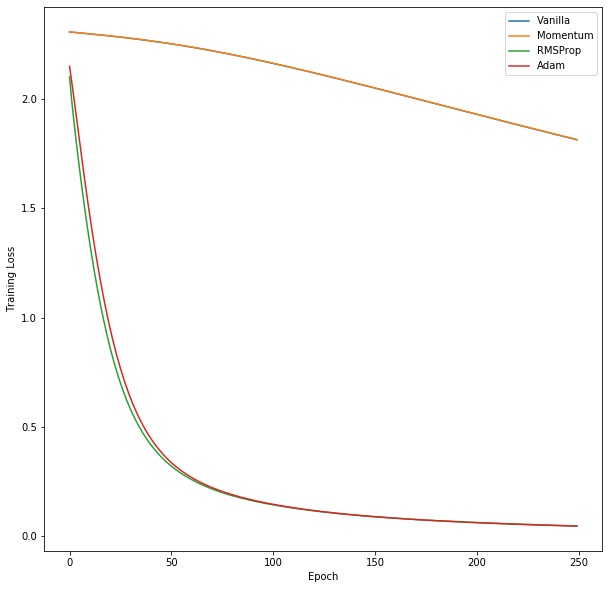

In [11]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,10)

plt.plot(vanilla_loss, label='Vanilla')
plt.plot(momentum_loss, label='Momentum')
plt.plot(RMS_loss, label='RMSProp')
plt.plot(Adam_loss, label='Adam')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()